In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
!pip install --upgrade scikit-learn

In [2]:
# Load the data
data = pd.read_csv('heart_disease_uci.csv')

# Define feature types
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Create a dictionary to specify column types
column_types = {feature: str for feature in categorical_features}
column_types.update({feature: float for feature in numeric_features})

# Convert columns to specified types
data = data.astype(column_types)

# Convert target variable to binary
data['num'] = (data['num'] > 0).astype(int)

# Display first few rows and data info
print(data.head())
print(data.info())

# Check unique values in categorical columns
for col in categorical_features:
    print(f"\nUnique values in {col}:")
    print(data[col].unique())

   id   age     sex    dataset               cp  trestbps   chol    fbs  \
0   1  63.0    Male  Cleveland   typical angina     145.0  233.0   True   
1   2  67.0    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3  67.0    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4  37.0    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5  41.0  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    1  
2  reversable defect    1  
3             normal    0  
4             normal    0  
<c

In [3]:
# Prepare features and target
X = data.drop(['id', 'dataset', 'num'], axis=1)
y = data['num']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipelines for each model
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=42))
    ])
}

In [4]:
# Train models and store results
results = {}
fitted_models = {}

for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    fitted_models[name] = model

    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }

# Print results
for name, metrics in results.items():
    print(f"\n{name} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Logistic Regression Results:
accuracy: 0.8207
precision: 0.8654
recall: 0.8257
f1: 0.8451
roc_auc: 0.9021

Random Forest Results:
accuracy: 0.8533
precision: 0.8942
recall: 0.8532
f1: 0.8732
roc_auc: 0.9152

SVM Results:
accuracy: 0.8750
precision: 0.9057
recall: 0.8807
f1: 0.8930
roc_auc: 0.9138


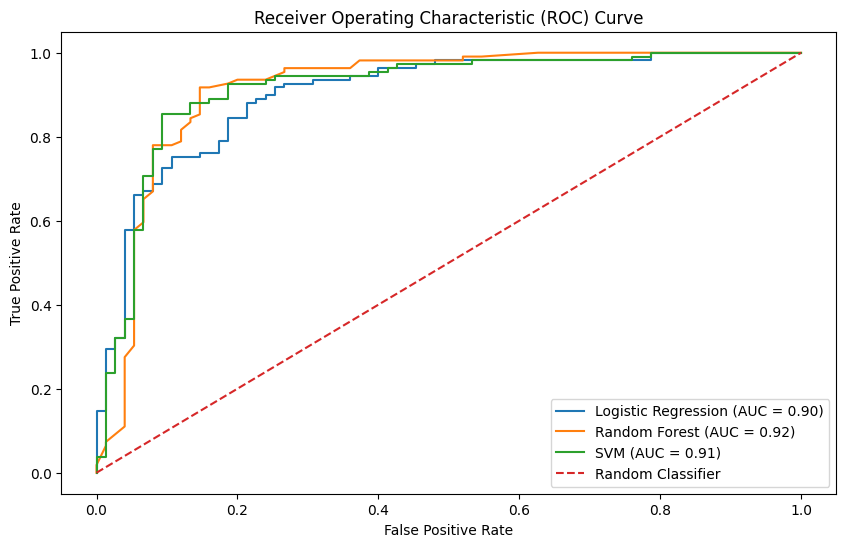

In [5]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
for name, model in fitted_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

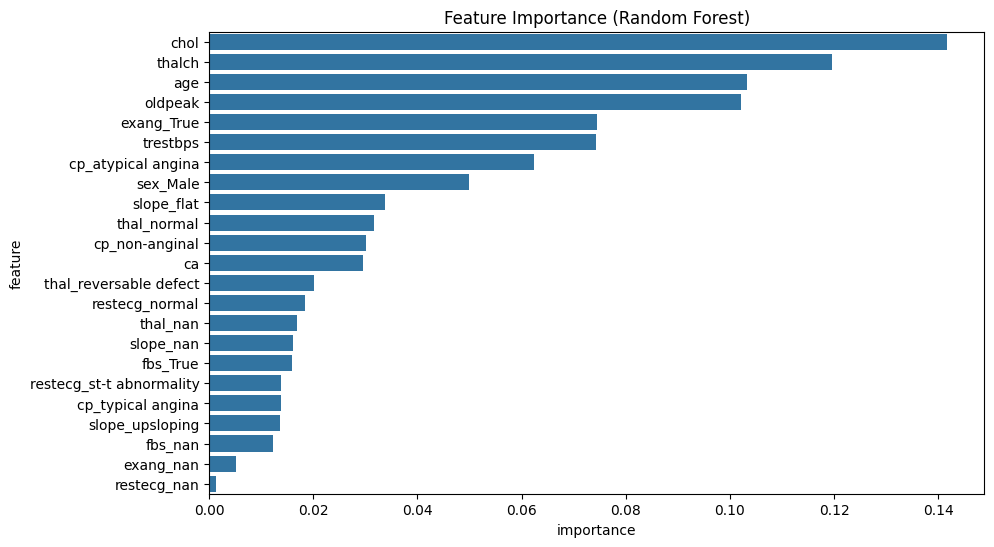

In [6]:
# Feature importance for Random Forest
rf_model = fitted_models['Random Forest'].named_steps['classifier']

# Get the feature names
onehot_encoder = fitted_models['Random Forest'].named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
if hasattr(onehot_encoder, 'get_feature_names_out'):
    # For newer scikit-learn versions
    cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features)
else:
    # For older scikit-learn versions
    cat_feature_names = onehot_encoder.get_feature_names(categorical_features)

feature_names = numeric_features + cat_feature_names.tolist()

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.show()